In [1]:
# reload the data

#imports
import pandas as pd
import numpy as np
import os
%matplotlib inline

# set the file paths for the data
raw_data_path = os.path.join(os.getcwd(), 'data', 'raw')
train_file_path = os.path.join(raw_data_path, 'train.csv')
test_file_path = os.path.join(raw_data_path, 'test.csv')

# import the data into pandas DataFrames, setting the PassengerID as the index column
train_df = pd.read_csv(train_file_path, index_col="PassengerId")
test_df = pd.read_csv(test_file_path, index_col="PassengerId")

# add a column for Survived to the test data
test_df['Survived'] = -888

df = pd.concat([train_df, test_df], axis=0)

# Data munging

This is the process of cleaning the dataset ready for use in predictive models.

The first step is to assess and replace any missing values in the dataset. There are two main ways to deal with missing values:

1. Deletion
2. Imputation (replacement)

The first option removes data, which is usually not what we want, so we usually use the second. There are various techniques used to find suitable values for imputation:

* Mean imputation (replace with the mean of the existing values)
* Median imputation (replace with the median of the existing values - outliers have less impact, so it's preferred mean)
* Mode imputation (categorical data, replace with the highest frequency value)
* Forward fill or back fill (use the next or previous value to fill in the gap)
* Predictive model (use a model to predict the best missing values

The first step is to assess which features contain missing values.

In [2]:
# Use info() to find out if there is missing data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
Age         1046 non-null float64
Cabin       295 non-null object
Embarked    1307 non-null object
Fare        1308 non-null float64
Name        1309 non-null object
Parch       1309 non-null int64
Pclass      1309 non-null int64
Sex         1309 non-null object
SibSp       1309 non-null int64
Survived    1309 non-null int64
Ticket      1309 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 122.7+ KB


## Feature: Embarked

In [3]:
# extract rows with null in the embarked column
df[df['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket
PassengerId,,,,,,,,,,,
62,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,1,female,0,1,113572
830,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,1,female,0,1,113572


In [4]:
# find the most common embarkment point
df['Embarked'].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [5]:
# Southampton looks like a good candidate for the replacement (mode imputation)
# both passengers survived, so we can also find out which embarked point had the highest survival rate to see if that
# backs up our Southampton choice
pd.crosstab(df[df.Survived != -888].Survived, df[df.Survived != -888].Embarked)

Embarked,C,Q,S
Survived,,,
0,75,47,427
1,93,30,217


There are two ways to fill in the 'S' value.

1. Use loc[] to extract the rows and assign the Embarked value to 'S'.
2. Use the fillna() function from pandas, which is designed for imputation and is much simpler syntax

For the fillna() function, use inplace=True to replace the values. If you use the default (which is False), pandas creates a new DataFrame which isn't the result we'd want in this case.

In [6]:
# options 1
#df.loc[df.Embarked.isnull(), 'Embarked'] = 'S'
# option 2
#df.Embarked.fillna('S', inplace=True)

Either of these two pieces of code could be used, but we're going to try to be a bit cleverer. Both of these passengers have a fare of 80.0 and they were in first class, so we can find out what the median fare was for first class passengers at each embarkation point and try to find the fare closest to 80.0.

In [7]:
df.groupby(['Pclass', 'Embarked']).Fare.median()

Pclass  Embarked
1       C           76.7292
        Q           90.0000
        S           52.0000
2       C           15.3146
        Q           12.3500
        S           15.3750
3       C            7.8958
        Q            7.7500
        S            8.0500
Name: Fare, dtype: float64

In [8]:
# from this observation, Southampton is much cheaper than the fare they paid. Cherbourg is actually a closer
# fare value, so it's more likely these passengers embarked at this point and 'C' therefore is a better value to use
df.Embarked.fillna('C', inplace=True)

In [9]:
# check if anything is still null
df[df.Embarked.isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket
PassengerId,,,,,,,,,,,


In [10]:
# check info again
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
Age         1046 non-null float64
Cabin       295 non-null object
Embarked    1309 non-null object
Fare        1308 non-null float64
Name        1309 non-null object
Parch       1309 non-null int64
Pclass      1309 non-null int64
Sex         1309 non-null object
SibSp       1309 non-null int64
Survived    1309 non-null int64
Ticket      1309 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 122.7+ KB


## Feature: Fare

In [11]:
df[df.Fare.isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket
PassengerId,,,,,,,,,,,
1044,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,3,male,0,-888,3701


In [12]:
# we can use the median fare of passengers travelling third class from Southampton
median_fare = df.loc[(df.Pclass == 3) & (df.Embarked == 'S'), 'Fare'].median()
print(median_fare)

8.05


In [13]:
df['Fare'].fillna(median_fare, inplace=True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
Age         1046 non-null float64
Cabin       295 non-null object
Embarked    1309 non-null object
Fare        1309 non-null float64
Name        1309 non-null object
Parch       1309 non-null int64
Pclass      1309 non-null int64
Sex         1309 non-null object
SibSp       1309 non-null int64
Survived    1309 non-null int64
Ticket      1309 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 122.7+ KB


## Feature: Age

This feature has a lot of missing values to fill in. To be exact, 263 rows are missing age data.

In [15]:
# you can set the max number of rows displayed by pandas, to avoid clutter in the notebook
pd.options.display.max_rows = 15

In [16]:
df[df['Age'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket
PassengerId,,,,,,,,,,,
6,NaN,NaN,Q,8.4583,"Moran, Mr. James",0,3,male,0,0,330877
18,NaN,NaN,S,13.0000,"Williams, Mr. Charles Eugene",0,2,male,0,1,244373
20,NaN,NaN,C,7.2250,"Masselmani, Mrs. Fatima",0,3,female,0,1,2649
27,NaN,NaN,C,7.2250,"Emir, Mr. Farred Chehab",0,3,male,0,0,2631
29,NaN,NaN,Q,7.8792,"O'Dwyer, Miss. Ellen ""Nellie""",0,3,female,0,1,330959
30,NaN,NaN,S,7.8958,"Todoroff, Mr. Lalio",0,3,male,0,0,349216
32,NaN,B78,C,146.5208,"Spencer, Mrs. William Augustus (Marie Eugenie)",0,1,female,1,1,PC 17569
...,...,...,...,...,...,...,...,...,...,...,...
1274,NaN,NaN,S,14.5000,"Risien, Mrs. Samuel (Emma)",0,3,female,0,-888,364498


### Option 1: replace age with mean age

This has the issue of potentially being distorted by outliers. Let's graph it!

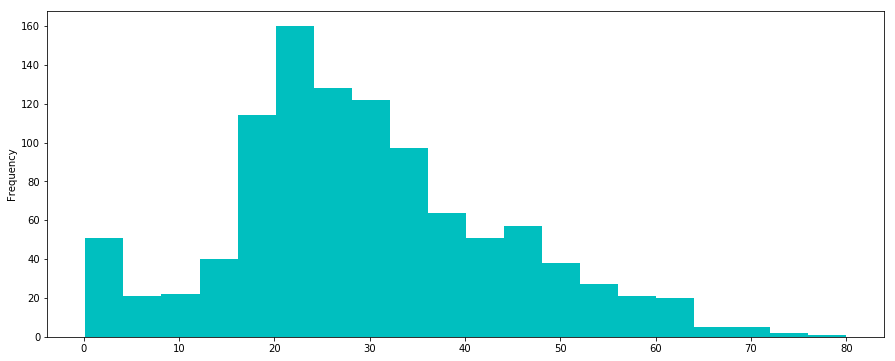

In [17]:
df.Age.plot(kind="hist", bins=20, color='c', figsize=(15,6))

In [18]:
# check the mean age
df['Age'].mean()

29.881137667304014

The mean age is roughly thirty, but most of the ages are clustered between twenties and thirties with a higher proportion in lower twenties (from box plot), so it looks like the mean is being increased by the small proportion of passengers with ages above 60. This does not make mean a good candidate for replacement.

### Option 2: replace with median of gender

It's possible the median age might vary by gender, so we shoud explore this possibility for a replacement strategy.

In [19]:
df.groupby(['Sex']).Age.median()

Sex
female    27.0
male      28.0
Name: Age, dtype: float64

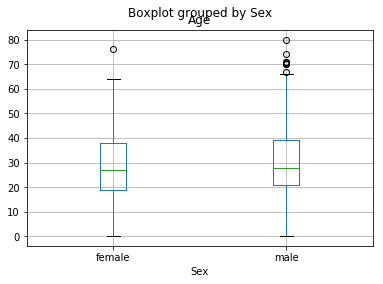

In [20]:
# not much difference, we could also try to visualise this to confirm
df[df.Age.notnull()].boxplot('Age', 'Sex')

There is very little difference in median age between sexes, so it's not worth doing this replacement. However, if we were, we could uncomment and use the following code.

In [21]:
# replace:
# gets a series with the median age (by sex) for every passenger ID
#age_sex_median = df.groupby(['Sex']).Age.transform('median')
# replace NAs with the age value calculated for that passenger ID in age_sex_median
#df.Age.fillna(age_sex_median, inplace=True)

### Option 3: replace with median age of Pclass

We can investigate the median age by class and see if that's a better candidate for calculating a median age.

In [22]:
df.groupby(['Pclass']).Age.median()

Pclass
1    39.0
2    29.0
3    24.0
Name: Age, dtype: float64

There are distinct differences in age coming through here, so it could be a good candidate.

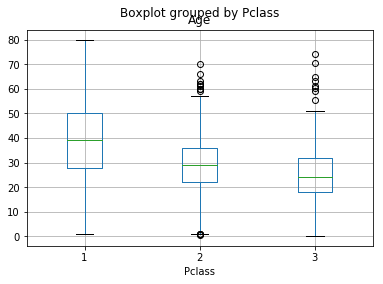

In [23]:
df[df.Age.notnull()].boxplot('Age', 'Pclass')

In [24]:
# if we wanted to use this as the basis for our age difference, we can use the same process as for sex above
#age_class_median = df.groupby(['Pclass']).Age.transform('median')
#df.Age.fillna(age_sex_median, inplace=True)

### Option 4: explore using the title of a passenger

Often, the title a passenger has tells us a lot about their social class, so that is a good candidate to explore if we don't want to simply go for class of travel.

In [25]:
df.Name

PassengerId
1                                 Braund, Mr. Owen Harris
2       Cumings, Mrs. John Bradley (Florence Briggs Th...
3                                  Heikkinen, Miss. Laina
4            Futrelle, Mrs. Jacques Heath (Lily May Peel)
5                                Allen, Mr. William Henry
6                                        Moran, Mr. James
7                                 McCarthy, Mr. Timothy J
                              ...                        
1303      Minahan, Mrs. William Edward (Lillian E Thorpe)
1304                       Henriksson, Miss. Jenny Lovisa
1305                                   Spector, Mr. Woolf
1306                         Oliva y Ocana, Dona. Fermina
1307                         Saether, Mr. Simon Sivertsen
1308                                  Ware, Mr. Frederick
1309                             Peter, Master. Michael J
Name: Name, Length: 1309, dtype: object

In [26]:
# the format of a passenger name is family name comma title full-stop other names. So write a function to extract title
def GetTitle(name):
    first_name_with_title = name.split(',')[1]
    title = first_name_with_title.split('.')[0]
    title = title.strip().lower()
    return title

In [27]:
# use map to apply the function to each row
df.Name.map(lambda x: GetTitle(x)) # alternatively you could use df.Name.map(GetTitle)

PassengerId
1           mr
2          mrs
3         miss
4          mrs
5           mr
6           mr
7           mr
         ...  
1303       mrs
1304      miss
1305        mr
1306      dona
1307        mr
1308        mr
1309    master
Name: Name, Length: 1309, dtype: object

In [28]:
# the unique() attribute can be used to get the unique titles
df.Name.map(lambda x: GetTitle(x)).unique() # alternatively you could use df.Name.map(GetTitle).unique()

array(['mr', 'mrs', 'miss', 'master', 'don', 'rev', 'dr', 'mme', 'ms',
       'major', 'lady', 'sir', 'mlle', 'col', 'capt', 'the countess',
       'jonkheer', 'dona'], dtype=object)

In [29]:
# to get a better collection of titles, we can make a change to the GetTitle() function to use a dictionary
# to look up standardised titles
def GetTitle(name):
    title_group = {'mr': 'Mr',
                  'mrs': 'Mrs',
                  'miss': 'Miss',
                  'master': 'Master',
                  'don': 'Sir',
                  'rev': 'Sir',
                  'dr': 'Officer',
                  'mme': 'Mrs',
                  'ms': 'Mrs',
                  'major': 'Officer',
                  'lady': 'Lady',
                  'sir': 'Sir',
                  'mlle': 'Miss',
                  'col': 'Officer',
                  'capt': 'Officer',
                  'the countess': 'Lady',
                  'jonkheer': 'Sir',
                  'dona': 'Lady'}
    first_name_with_title = name.split(',')[1]
    title = first_name_with_title.split('.')[0]
    title = title.strip().lower()
    return title_group[title]

In [30]:
# create Title feature
df['Title'] = df.Name.map(lambda x: GetTitle(x))

In [31]:
df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,Title
PassengerId,,,,,,,,,,,,
1,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,0,A/5 21171,Mr
2,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,1,PC 17599,Mrs
3,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,1,STON/O2. 3101282,Miss
4,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,1,113803,Mrs
5,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,3,male,0,0,373450,Mr


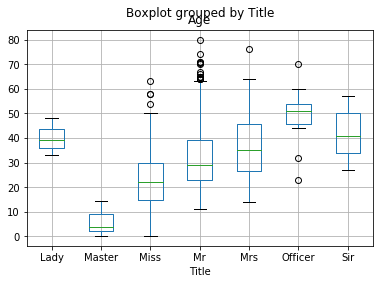

In [32]:
df[df.Age.notnull()].boxplot('Age', 'Title')

This is the best candidate we have seen so far, so we're going to use it. If you think about the socioeconomic model of people in the early twentieth century, of course age will correlate better to title than to gender or class on their own: title combines elements of both to predict age.

In [33]:
# replace:
# gets a series with the median age (by title) for every passenger ID
age_title_median = df.groupby(['Title']).Age.transform('median')
# replace NAs with the age value calculated for that passenger ID in age_sex_median
df.Age.fillna(age_title_median, inplace=True)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 12 columns):
Age         1309 non-null float64
Cabin       295 non-null object
Embarked    1309 non-null object
Fare        1309 non-null float64
Name        1309 non-null object
Parch       1309 non-null int64
Pclass      1309 non-null int64
Sex         1309 non-null object
SibSp       1309 non-null int64
Survived    1309 non-null int64
Ticket      1309 non-null object
Title       1309 non-null object
dtypes: float64(2), int64(4), object(6)
memory usage: 172.9+ KB


We have imputed missing values for all features except Cabin, which is only available for a small proportion of passengers. That makes it not useful for predictive models, but it can be used for some elements of feature engineering later.

## Working with outliers

One of the keys is to detect outliers. There are various methods, ranging from simple to complex algorithms.

If you are only working with one feature, plotting a histogram will highlight extreme values in data. Boxplots are also useful for univariate outlier detection (such as for age above). Dots more than 1.5 times the interquartile range will be treated as outliers in a box plot. A scatter plot is another good tool for detecting outliers in bivariant distribution.

The simplest way to deal with outliers is to remove those records, but you might be removing some important information for features that are not outliers.

Another option is to apply transformation on features to treat outliers. For example, taking a log of square root of a feature to reduce the impact of outliers.

Binning is another potential technique. Put the values of a feature into different bins and perhaps put all the outliers in their own bin as part of that.

Imputation can also be used to replace outliers, using other information (such as with age above) to find more suitable values to replace the outliers with.

You may not want to do any of this and just leave the outliers in, but if you do, they should be explored. There may be very useful information in them that can really help.

### Age

We will examine age first, by creating a histogram to visualise.

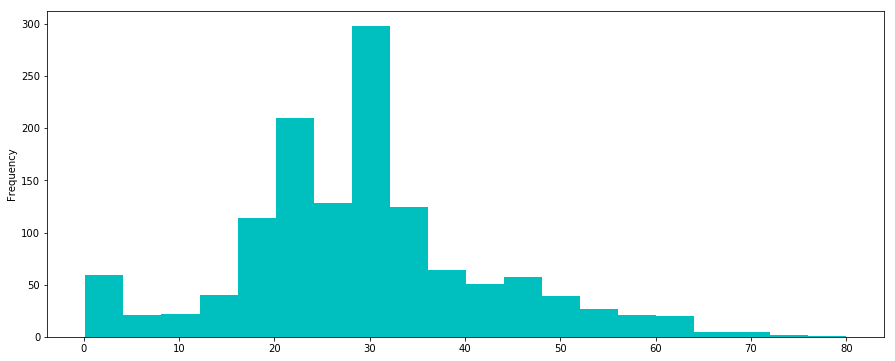

In [36]:
df.Age.plot(kind="hist", bins=20, color="c", figsize=(15,6));

In [37]:
df.loc[df.Age > 70]

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,Title
PassengerId,,,,,,,,,,,,
97,71.0,A5,C,34.6542,"Goldschmidt, Mr. George B",0,1,male,0,0,PC 17754,Mr
117,70.5,NaN,Q,7.7500,"Connors, Mr. Patrick",0,3,male,0,0,370369,Mr
494,71.0,NaN,C,49.5042,"Artagaveytia, Mr. Ramon",0,1,male,0,0,PC 17609,Mr
631,80.0,A23,S,30.0000,"Barkworth, Mr. Algernon Henry Wilson",0,1,male,0,1,27042,Mr
852,74.0,NaN,S,7.7750,"Svensson, Mr. Johan",0,3,male,0,0,347060,Mr
988,76.0,C46,S,78.8500,"Cavendish, Mrs. Tyrell William (Julia Florence...",0,1,female,1,-888,19877,Mrs


There are 6 passengers aged over seventy. None of them look unfeasibly old, although they are significantly older than the majority of passengers.

### Fare

We can also check fare for outliers in the same way.

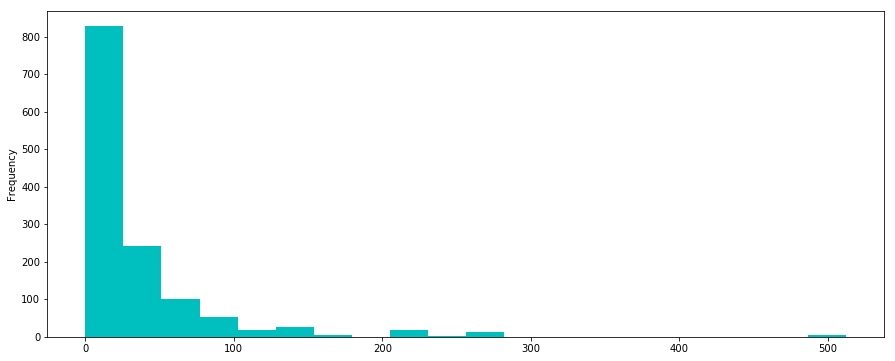

In [38]:
df.Fare.plot(kind="hist", bins=20, color="c", figsize=(15,6))

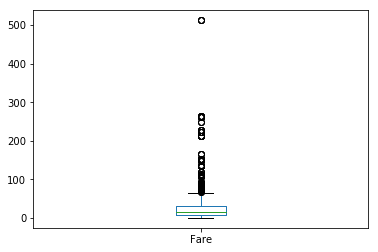

In [39]:
# there are some passengers with a very high fare. Confirm this with a box plot
df.Fare.plot(kind="box");

In [40]:
# explore the outliers - look at rows where passenger fare is equal to maximum fare
df[df.Fare == df.Fare.max()]

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,Title
PassengerId,,,,,,,,,,,,
259,35.0,NaN,C,512.3292,"Ward, Miss. Anna",0,1,female,0,1,PC 17755,Miss
680,36.0,B51 B53 B55,C,512.3292,"Cardeza, Mr. Thomas Drake Martinez",1,1,male,0,1,PC 17755,Mr
738,35.0,B101,C,512.3292,"Lesurer, Mr. Gustave J",0,1,male,0,1,PC 17755,Mr
1235,58.0,B51 B53 B55,C,512.3292,"Cardeza, Mrs. James Warburton Martinez (Charlo...",1,1,female,0,-888,PC 17755,Mrs


All these passengers paid the same amount and have the same ticket type, so it's likely they were travelling together. They are all first class passengers, so possibly they booked at the last minute and had to pay a premium. Two of the passengers shared a cabin (and surname) so perhaps they are related? They have a 1 for the Parch, so it's possible they were mother and son, backed up by their surnames. Three of these passengers survived, and one has a survived value of -888 so she is in the test dataset. We don't want to remove these passengers because they have useful data.

In [41]:
# try some transformation to make it less skewed
LogFare = np.log(df.Fare + 1.0) # add 1 to accomodate zero fares: log(0) is undefined

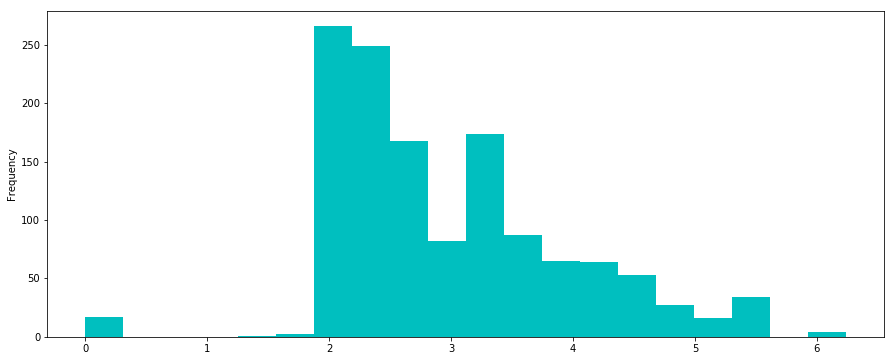

In [42]:
# histograph of logfare
LogFare.plot(kind="hist", bins=20, color="c", figsize=(15,6));

The cut() or qcut() functions from pandas can be used to for binning, which is one way of treating outliers. The qcut function performs quantile binning.

In [43]:
# creates bins and labels them by the range of the bin
pd.qcut(df.Fare, 4)

PassengerId
1         (-0.001, 7.896]
2       (31.275, 512.329]
3         (7.896, 14.454]
4       (31.275, 512.329]
5         (7.896, 14.454]
6         (7.896, 14.454]
7       (31.275, 512.329]
              ...        
1303    (31.275, 512.329]
1304      (-0.001, 7.896]
1305      (7.896, 14.454]
1306    (31.275, 512.329]
1307      (-0.001, 7.896]
1308      (7.896, 14.454]
1309     (14.454, 31.275]
Name: Fare, Length: 1309, dtype: category
Categories (4, interval[float64]): [(-0.001, 7.896] < (7.896, 14.454] < (14.454, 31.275] < (31.275, 512.329]]

In [44]:
pd.qcut(df.Fare, 4, labels=['very_low', 'low', 'high', 'very_high']) #discreetization

PassengerId
1        very_low
2       very_high
3             low
4       very_high
5             low
6             low
7       very_high
          ...    
1303    very_high
1304     very_low
1305          low
1306    very_high
1307     very_low
1308          low
1309         high
Name: Fare, Length: 1309, dtype: category
Categories (4, object): [very_low < low < high < very_high]

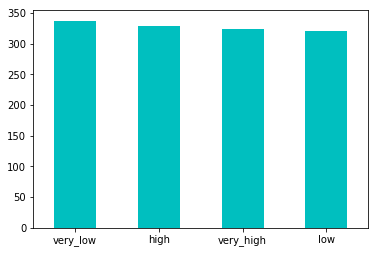

In [45]:
# we can plot this to find the distribution
pd.qcut(df.Fare, 4, labels=['very_low', 'low', 'high', 'very_high']).value_counts().plot(kind="bar", color="c", rot=0)

In [46]:
df['Fare_Bin'] = pd.qcut(df.Fare, 4, labels=['very_low', 'low', 'high', 'very_high'])

In [47]:
df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,Title,Fare_Bin
PassengerId,,,,,,,,,,,,,
1,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,0,A/5 21171,Mr,very_low
2,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,1,PC 17599,Mrs,very_high
3,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,1,STON/O2. 3101282,Miss,low
4,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,1,113803,Mrs,very_high
5,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,3,male,0,0,373450,Mr,low


# Feature Engineering

Creating the title and fare_bine features was actually some feature engineering! It's one of the most crucial aspects of a data science project title.

It is the process of transforming raw data to have better representative features in order to create better predictive models.

There are several key aspects:

* Transformation of existing features (such as taking a log to reduce outlier influence)
* Feature creation (using domain expertise to create new features out of existing ones)
* Selection (use domain expertise or algorithms to select the most important features to use)

At it's heart, feature engineering is a key process that combines technical and domain expertise to get the best set of features for predictive models.

## Feature: AgeState (Adult or Child)

In [48]:
# AgeState based on age
# the numpy where() function takes a boolean comparitor, and two fields, one for True and one for False
df['AgeState'] = np.where(df['Age'] >= 18, 'Adult', 'Child')

In [49]:
df['AgeState'].value_counts()

Adult    1147
Child     162
Name: AgeState, dtype: int64

In [50]:
# crosstab
pd.crosstab(df[df.Survived != -888].Survived, df[df.Survived != -888].AgeState)

AgeState,Adult,Child
Survived,,
0,495,54
1,279,63


A much higher proportion of children survived than adults, so this is a significant feature to use.

## Feature: FamilySize

In [51]:
# Family: Adding parents with siblings plus 1 for self
df['FamilySize'] = df['Parch'] + df['SibSp'] + 1

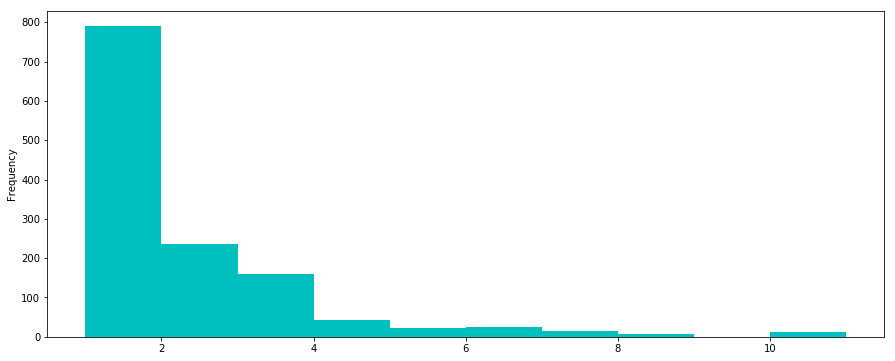

In [52]:
# explore the family size feature
df['FamilySize'].plot(kind="hist", color="c", figsize=(15,6));

In [53]:
# we should take a look at the really big family
df.loc[df.FamilySize == df.FamilySize.max()]

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,Title,Fare_Bin,AgeState,FamilySize
PassengerId,,,,,,,,,,,,,,,
160,4.0,NaN,S,69.55,"Sage, Master. Thomas Henry",2,3,male,8,0,CA. 2343,Master,very_high,Child,11
181,22.0,NaN,S,69.55,"Sage, Miss. Constance Gladys",2,3,female,8,0,CA. 2343,Miss,very_high,Adult,11
202,29.0,NaN,S,69.55,"Sage, Mr. Frederick",2,3,male,8,0,CA. 2343,Mr,very_high,Adult,11
325,29.0,NaN,S,69.55,"Sage, Mr. George John Jr",2,3,male,8,0,CA. 2343,Mr,very_high,Adult,11
793,22.0,NaN,S,69.55,"Sage, Miss. Stella Anna",2,3,female,8,0,CA. 2343,Miss,very_high,Adult,11
847,29.0,NaN,S,69.55,"Sage, Mr. Douglas Bullen",2,3,male,8,0,CA. 2343,Mr,very_high,Adult,11
864,22.0,NaN,S,69.55,"Sage, Miss. Dorothy Edith ""Dolly""",2,3,female,8,0,CA. 2343,Miss,very_high,Adult,11
1080,22.0,NaN,S,69.55,"Sage, Miss. Ada",2,3,female,8,-888,CA. 2343,Miss,very_high,Adult,11
1234,29.0,NaN,S,69.55,"Sage, Mr. John George",9,3,male,1,-888,CA. 2343,Mr,very_high,Adult,11


This is one large family - two parents and their nine children. The Parch and SibSp columns back that up. The children all have Parch of 2 and 8 SibSp, the parents have Parch of 9 and SibSp of 1. They all travelled on the same ticket, which was probably expensive due to the size of the family. They were all third class.

Seven did not survive. The other four are in the test data set, but it would not be unreasonable to think they might not have survived, due to their class and combination of age/gender.

In [54]:
pd.crosstab(df[df.Survived != -888].Survived, df[df.Survived != -888].FamilySize)

FamilySize,1,2,3,4,5,6,7,8,11
Survived,,,,,,,,,
0,374,72,43,8,12,19,8,6,7
1,163,89,59,21,3,3,4,0,0


For small families, the odds of survival were higher. It is possible that if one member of a family got to a lifeboat, they were able to get other members in. People who had no family were least likely to survive.

## Feature: IsMother

It is possible that mothers with babies could have been given priority over others, so this is good to explore.

In [56]:
df['IsMother'] = np.where(((df.Sex == 'female') & (df.Parch > 0) & (df.Age > 18) & (df.Title != 'Miss')), 1, 0)

In [57]:
# cross tab
pd.crosstab(df[df.Survived != -888].Survived, df[df.Survived != -888].IsMother)

IsMother,0,1
Survived,,
0,533,16
1,303,39


There are only a small number of mothers, but more of them survived than the non-mothers, so it had an impact.

## Feature: Deck

This can give useful information about where the passenger was. It can also give useful socio-economic information on the status of the passenger, which may have an impact on the passenger's survival and availability of lifeboats.

On initial examination, it looks like the first letter of the cabin number might correspond to a deck. There are a large number of NaNs, too, so it is possible those passengers were not assigned any particular cabin.

In [58]:
# explore the cabin information
df.Cabin

PassengerId
1        NaN
2        C85
3        NaN
4       C123
5        NaN
6        NaN
7        E46
        ... 
1303     C78
1304     NaN
1305     NaN
1306    C105
1307     NaN
1308     NaN
1309     NaN
Name: Cabin, Length: 1309, dtype: object

In [60]:
df.Cabin.unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6', 'C23 C25 C27',
       'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33', 'F G73', 'E31',
       'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101', 'F E69', 'D47',
       'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4', 'A32', 'B4',
       'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35', 'C87', 'B77',
       'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19', 'B49', 'D',
       'C22 C26', 'C106', 'C65', 'E36', 'C54', 'B57 B59 B63 B66', 'C7',
       'E34', 'C32', 'B18', 'C124', 'C91', 'E40', 'T', 'C128', 'D37',
       'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44', 'A34', 'C104', 'C111',
       'C92', 'E38', 'D21', 'E12', 'E63', 'A14', 'B37', 'C30', 'D20',
       'B79', 'E25', 'D46', 'B73', 'C95', 'B38', 'B39', 'B22', 'C86',
       'C70', 'A16', 'C101', 'C68', 'A10', 'E68', 'B41', 'A20', 'D19',
       'D50', 'D9', 'A23', 'B50', 'A26', 'D48', 'E58', 'C126', 'B71',
       'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63', 'C62 C64', 'E24',

In [61]:
# investigate passengers in cabin T, which is different from all other cabin number patterns
df[df.Cabin == 'T']

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,Title,Fare_Bin,AgeState,FamilySize,IsMother
PassengerId,,,,,,,,,,,,,,,,
340,45.0,T,S,35.5,"Blackwell, Mr. Stephen Weart",0,1,male,0,0,113784,Mr,very_high,Adult,1,0


In [62]:
# we don't want to create one deck for one passenger, so we assume this is an error and change it to NaN
df.loc[df.Cabin=='T', 'Cabin'] = np.nan

In [63]:
df.Cabin.unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6', 'C23 C25 C27',
       'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33', 'F G73', 'E31',
       'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101', 'F E69', 'D47',
       'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4', 'A32', 'B4',
       'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35', 'C87', 'B77',
       'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19', 'B49', 'D',
       'C22 C26', 'C106', 'C65', 'E36', 'C54', 'B57 B59 B63 B66', 'C7',
       'E34', 'C32', 'B18', 'C124', 'C91', 'E40', 'C128', 'D37', 'B35',
       'E50', 'C82', 'B96 B98', 'E10', 'E44', 'A34', 'C104', 'C111', 'C92',
       'E38', 'D21', 'E12', 'E63', 'A14', 'B37', 'C30', 'D20', 'B79',
       'E25', 'D46', 'B73', 'C95', 'B38', 'B39', 'B22', 'C86', 'C70',
       'A16', 'C101', 'C68', 'A10', 'E68', 'B41', 'A20', 'D19', 'D50',
       'D9', 'A23', 'B50', 'A26', 'D48', 'E58', 'C126', 'B71',
       'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63', 'C62 C64', 'E24', 'C90

In [64]:
# extract first letter of cabin and use this as deck, use Z for cabins that are null
def get_deck(cabin):
    return np.where(pd.notnull(cabin), str(cabin)[0].upper(), 'Z')
df['Deck'] = df['Cabin'].map(lambda x: get_deck(x))

In [66]:
df.Deck.value_counts()

Z    1015
C      94
B      65
D      46
E      41
A      22
F      21
G       5
Name: Deck, dtype: int64

In [67]:
# cross tab
pd.crosstab(df[df.Survived != -888].Survived, df[df.Survived != -888].Deck)

Deck,A,B,C,D,E,F,G,Z
Survived,,,,,,,,
0,8,12,24,8,8,5,2,482
1,7,35,35,25,24,8,2,206


In [68]:
# decks B, C, D, and E have a higher rate of survival, so deck does seem to have some influence
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 17 columns):
Age           1309 non-null float64
Cabin         294 non-null object
Embarked      1309 non-null object
Fare          1309 non-null float64
Name          1309 non-null object
Parch         1309 non-null int64
Pclass        1309 non-null int64
Sex           1309 non-null object
SibSp         1309 non-null int64
Survived      1309 non-null int64
Ticket        1309 non-null object
Title         1309 non-null object
Fare_Bin      1309 non-null category
AgeState      1309 non-null object
FamilySize    1309 non-null int64
IsMother      1309 non-null int64
Deck          1309 non-null object
dtypes: category(1), float64(2), int64(6), object(8)
memory usage: 215.3+ KB


Most machine learning algorithms can only work on numerical columns. The columns that are objects or categories are useful and many of them are categorical, but they need to be reinterpreted as numbers to make them available to machine learning algorithms.

# Categorical Feature Encoding

The process of turning categorical features into numerical features, to enable them to be used by machine learning algorithms.